# Recipe Site Traffic -predictions


## Part 1

Importing and cleanind the data.

Adjusted category column to adhere to 10 categories.

Servings column was also adjusted to be numeric. 

There are 52 recipes which have no nutritional information, it was decided to remove them. Another possibility would be to use imputers, but it could potentialy skew the results.

High traffic column was transofmred to a boolean.

Outliers of calories, carbohydrate, sugar and protein columns were removed, only the upper limited outliers removed since the data is skewed. 



In [22]:
#first imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('recipe_site_traffic_2212.csv')

print(df.head())
#column cleanup
df['category'] = df['category'].str.replace('Chicken Breast','Chicken')
print(df.category.unique())

df['servings'] = df['servings'].str.replace('4 as a snack','4')
df['servings'] = df['servings'].str.replace('6 as a snack','6').astype('int')
#print(df.servings.unique())
df.dropna(inplace=True,subset=['calories','carbohydrate','sugar','protein'])
#for col in ['calories','carbohydrate','sugar','protein']:
#   df[col].fillna((df[col].mean()), inplace=True)


df['high_traffic'].fillna('0',inplace=True)
df['high_traffic'].replace('High','1',inplace=True)
df['high_traffic']=df['high_traffic'].astype('int')

print(df.head())
print(df.dtypes)
print(df.isnull().sum())
#df=df.fillna('0')

#import seaborn as sns
#for column in df:
#    plt.figure()
#    df.boxplot([column])

for col in ['calories','carbohydrate','sugar','protein']:
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    percentile96 = df[col].quantile(.96)
    iqr = percentile75 - percentile25
    
    #upper_limit = percentile75 + 1.5 * iqr
    upper_limit = percentile96
    lower_limit = percentile25 - 1.5 * iqr

    df = df[df[col] < upper_limit]



   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85  ...  Beverages         4          NaN

[5 rows x 8 columns]
['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
   recipe  calories  carbohydrate  ...       category  servings high_traffic
1       2     35.48         38.56  ...         Potato         4            1
2       3    914.28         42.68  ...      Breakfast         1            0
3       4     97.03         30.56  ...      Beverages         4            1
4       5     27.05          1.85  ...      Beverages         4            0
5       6    691.15          3.46  ...  On

Chicken          134
Breakfast         99
Beverages         85
Vegetable         78
Lunch/Snacks      73
Potato            71
Pork              61
Meat              60
One Dish Meal     54
Dessert           44
Name: category, dtype: int64

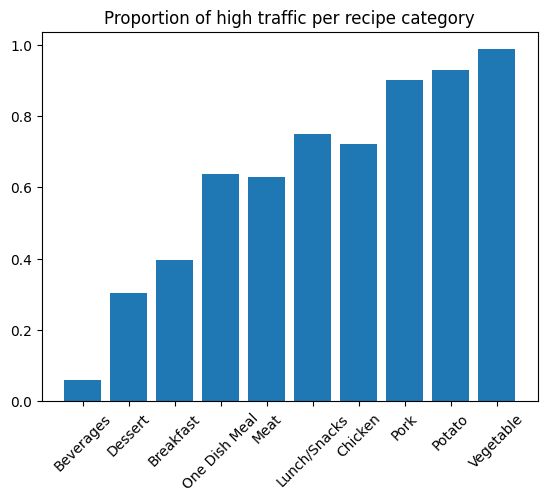

In [23]:
dfchart = df.groupby(['category']).sum()
plt.title("Proportion of high traffic per recipe category")
plt.xticks(rotation=45)
dfchart.sort_values(by=['high_traffic'], inplace=True)
plt.bar(dfchart.index,dfchart["high_traffic"]/df['category'].value_counts())
df['category'].value_counts()

## Part 2

Looking at the categories and what part of recipes have high traffic, we can see that pork, vegetable and potato categories have the highest proportion of high traffic recipes.
On the other end beverage category has close to zero high traffic recipes.

Text(0, 0.5, 'Number of recipes')

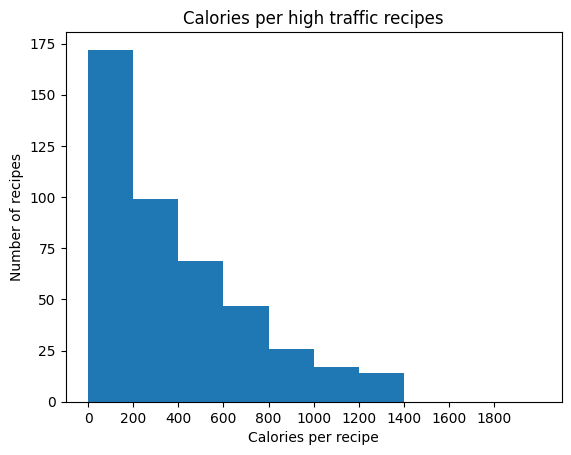

In [24]:
plt.title("Calories per high traffic recipes")
plt.xticks(np.arange(0.0, 2000.0, step=200.0))
plt.hist(df['calories'][df['high_traffic']==1].astype('float'),bins=10,range=(0.0,2000.0))
df['high_traffic'].value_counts()
plt.xlabel('Calories per recipe')
plt.ylabel('Number of recipes')

Looking at the histogram of calories per recipe, it is clear that most high traffic calories are in the lower ranges, biggest part being recipes under 400 calories.

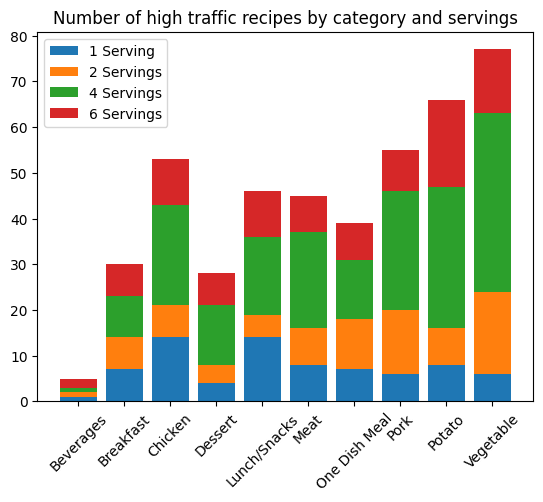

In [25]:
df1 = df.groupby(['category']).count()
s1= df[(df['servings']==1)&(df['high_traffic']==1)].groupby(['category']).count()
s2= df[(df['servings']==2)&(df['high_traffic']==1)].groupby(['category']).count()
s4= df[(df['servings']==4)&(df['high_traffic']==1)].groupby(['category']).count()
s6= df[(df['servings']==6)&(df['high_traffic']==1)].groupby(['category']).count()
X_axis = np.arange(len(df1.index))
plt.title("Number of high traffic recipes by category and servings")
plt.xticks(X_axis,df1.index,rotation=45)
plt.bar(X_axis, s1.servings, width=0.8, label='1 Serving')
plt.bar(X_axis , s2.servings, width=0.8,  label='2 Servings',bottom = s1.servings)
plt.bar(X_axis , s4.servings, width=0.8, label='4 Servings', bottom = s1.servings + s2.servings)
plt.bar(X_axis , s6.servings, width=0.8, label='6 Servings', bottom = s1.servings+s2.servings+s4.servings)
plt.legend(loc='upper left')
plt.show()

Looking at the high traffic recipes by category and servings, we can see that serving sizes are distributed in a similar way per category. In most cases 4 servings is the biggest category, other three serving size recipe number being similar per category.

## Part 3

This is a binary categorization problem, so model fit for categorization will be used. 

Firstly X and y of the dataset were split. Dummy variables were added to convert categorical values. Servings column was encoded using ordinal encoding. 

Then train, test splits were created.

Standard scaler was applied and PCA test ran to determine the number of components to be used, which comes to 12.


In [26]:
#importing libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#creating test train splits
print(df['high_traffic'].value_counts())

#Yes_only = df.loc[df['high_traffic'] == 1]
#No_only = df.loc[df['high_traffic'] == 0]
#Yes_only = Yes_only.sample(No_only.shape[0], random_state=7)
#df = pd.concat([No_only, Yes_only])
#print(df['high_traffic'].value_counts())
y=df['high_traffic']
X= df.drop(["recipe","high_traffic"],axis=1)
X= pd.get_dummies(X,columns=['category'])

#enc = OrdinalEncoder()
#X["servings"] = enc.fit_transform(X[["servings"]])


le = LabelEncoder()
X["servings"] = le.fit_transform(X["servings"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3,stratify=y)



#scaling variables
scaler = StandardScaler()
#scaler= MinMaxScaler()
scaled_train_X = scaler.fit_transform(X_train)


#PCA
pca=PCA()
pca.fit(scaled_train_X)
exp_variance = pca.explained_variance_ratio_
cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)
#plt.plot(cum_exp_variance)
#plt.axhline(y=0.9)
#plt.show()

pca = PCA(n_components=12,random_state=7)

train_pca = pca.fit_transform(scaled_train_X)

scaled_test_X = scaler.transform(X_test)
test_pca = pca.transform(scaled_test_X)




1    444
0    315
Name: high_traffic, dtype: int64
[0.12119563 0.21748819 0.30903728 0.39172006 0.46743319 0.54220398
 0.61666702 0.68974381 0.76247637 0.82337691 0.87942459 0.92693413
 0.97084251 1.         1.        ]


## Part 4 

Firstly a **logistic regression model** will be used. Grid search cross validation is also used to determine optimum parameters for the model. We get an accuracy of **0.745**, F1 score of **0.780**, ROC AUC score of **0.797**.

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
{'C': 0.0001, 'max_iter': 100, 'penalty': 'none', 'solver': 'lbfgs'}
0.7759125374713454
Logistic Regression: 
               precision    recall  f1-score   support

           0       0.69      0.71      0.70        95
           1       0.79      0.77      0.78       133

    accuracy                           0.75       228
   macro avg       0.74      0.74      0.74       228
weighted avg       0.75      0.75      0.75       228

Accuracy Score: 0.7456140350877193
F1 score: 0.7803030303030303


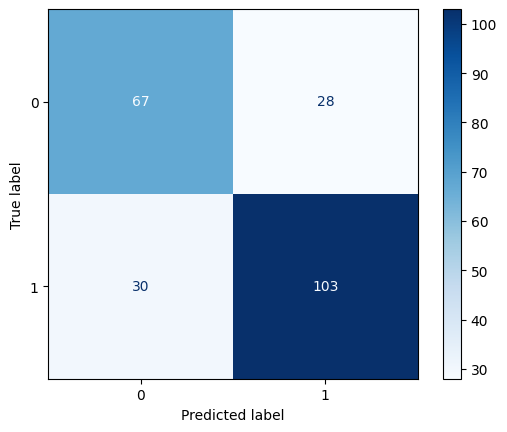

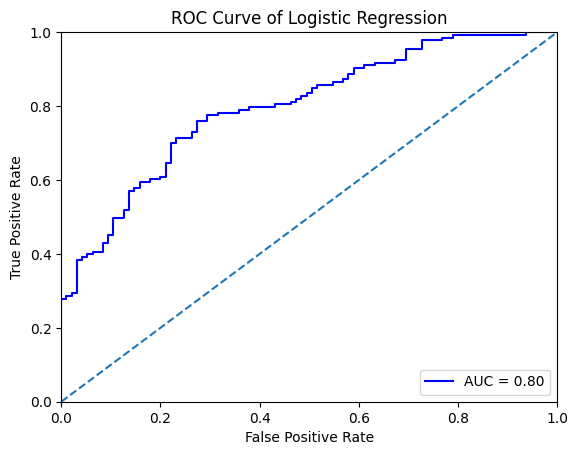

ROC AUC score: 
 0.7974673525920063


In [27]:
#logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=3)
parameters = [    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }]
grid_search = GridSearchCV(estimator = logreg, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=1, refit=True)
grid_search.fit(train_pca, y_train)

#logreg.fit(train_pca,y_train)
#pred_y_log = logreg.predict(test_pca)
pred_y_log = grid_search.best_estimator_.predict(test_pca)
print(grid_search.best_params_)
print(grid_search.best_score_)


#inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
#outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
# Non_nested parameter search and scoring
#    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
#    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
#    nested_scores[i] = nested_score.mean()

from sklearn.metrics import classification_report, accuracy_score, f1_score
class_log = classification_report(y_test,pred_y_log)
print("Logistic Regression: \n", class_log)
print("Accuracy Score:",accuracy_score(y_test,pred_y_log))
print("F1 score:",f1_score(y_test,pred_y_log))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,pred_y_log), display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
plt.show()

import scikitplot as skplt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

y_scores = grid_search.predict_proba(test_pca)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()


print("ROC AUC score: \n",roc_auc_score(y_test, y_scores[:, 1]))

Secondly **K-Nearest Neighbors classifier** will be used. Following the same logic, grid search CV will be used to determine the optimum parameters. We get scores lowe than Logistical Regression: accuracy **0.715** , F1 score of **0.760**, ROC AUC score of **0.761**.

Fitting 5 folds for each of 32 candidates, totalling 160 fits
tuned hpyerparameters :(best parameters)  {'leaf_size': 15, 'n_neighbors': 8, 'weights': 'distance'}
0.7815376476811849
KNN: 
               precision    recall  f1-score   support

           0       0.67      0.63      0.65        95
           1       0.75      0.77      0.76       133

    accuracy                           0.71       228
   macro avg       0.71      0.70      0.70       228
weighted avg       0.71      0.71      0.71       228

Accuracy Score: 0.7149122807017544
F1 score: 0.7601476014760149


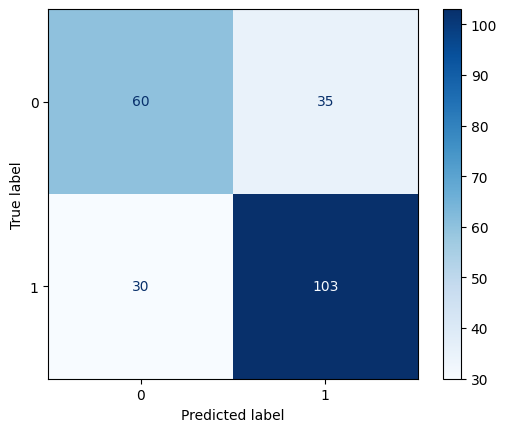

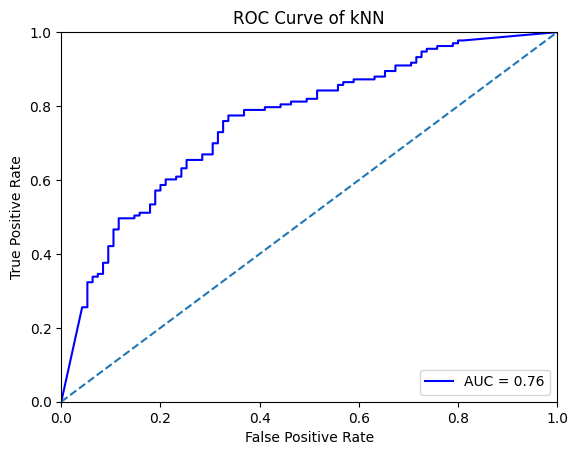

ROC AUC score: 
 0.7609814008705975


In [28]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
params1 = [{'n_neighbors': [2, 3,4, 5,6, 7,8, 9],
         'weights': ['uniform', 'distance'],
         'leaf_size': [15, 20]}]
gs_knn = GridSearchCV(estimator = KNN,
                      param_grid=params1,
                      scoring='accuracy',
                      cv=5, verbose=1, refit=True)
gs_knn.fit(train_pca,y_train)

pred_y_KNN = gs_knn.best_estimator_.predict(test_pca)


print("tuned hpyerparameters :(best parameters) ",gs_knn.best_params_)
print(gs_knn.best_score_)


class_log = classification_report(y_test,pred_y_KNN)
print("KNN: \n", class_log)
print("Accuracy Score:",accuracy_score(y_test,pred_y_KNN))
print("F1 score:",f1_score(y_test,pred_y_KNN))


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,pred_y_KNN), display_labels=gs_knn.classes_)
disp.plot(cmap='Blues')
plt.show()


y_scores = gs_knn.predict_proba(test_pca)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()
print("ROC AUC score: \n",roc_auc_score(y_test, y_scores[:, 1]))

Finally we also fit a **xgboost model**, which is an ensamble model and potentially could yield higher accuracy. However we get a lower result yet again: accuracy **0.667**, F1 score **0.714**, ROC AUC **0.748**

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.2}
0.7777777777777778
XGB: 
               precision    recall  f1-score   support

           0       0.60      0.60      0.60        95
           1       0.71      0.71      0.71       133

    accuracy                           0.67       228
   macro avg       0.66      0.66      0.66       228
weighted avg       0.67      0.67      0.67       228

Accuracy Score: 0.6666666666666666
F1 score: 0.7142857142857143


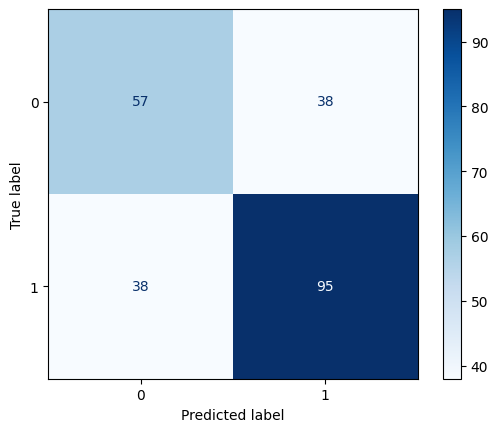

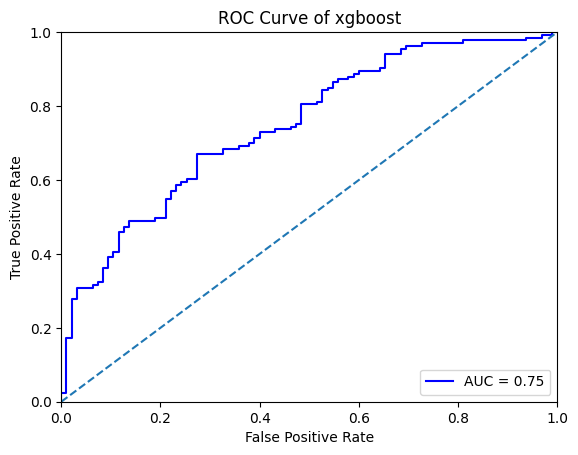

ROC AUC score: 
 0.747605856747131


In [29]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

y_train1 = y_train.str.replace('Omega',1)
y_train1 = y_train1.str.replace('Breitling',0)
y_test1 = y_test.str.replace('Omega',1)
y_test1 = y_test1.str.replace('Breitling',0)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
params =  {'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(train_pca, y_train1)

print(search.best_params_)
print(search.best_score_)

best_search = search.best_estimator_

pred_y_xg = best_search.predict(test_pca)

class_log = classification_report(y_test1,pred_y_xg)
print("XGB: \n", class_log)
print("Accuracy Score:",accuracy_score(y_test1,pred_y_xg))
print("F1 score:",f1_score(y_test1,pred_y_xg))


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,pred_y_xg), display_labels=best_search.classes_)
disp.plot(cmap='Blues')
plt.show()


y_scores = best_search.predict_proba(test_pca)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of xgboost')
plt.show()
print("ROC AUC score: \n",roc_auc_score(y_test, y_scores[:, 1]))

Finally cross validation score will be used for additional 4  models, just to make sure we are not missing a model, which is signifanctly more accurate. 

The 4 additional models are LinearSVC, Decision Tree Classifier, Random Forest Classifier, GaussianNB.

We couldn't get a higher result with any of the other models, meaning our Logistic Regression model performs the best.


In [30]:
# Start coding here... 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


linear_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=12)), ("logreg", LinearSVC(random_state=7))])
DTC_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=12)), ("logreg", DecisionTreeClassifier(random_state=7))])
RFC_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=12)), ("logreg", RandomForestClassifier(random_state=7))])
GNB_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=12)), ("logreg", GaussianNB())])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=12)), ("logreg", LogisticRegression(random_state=7))])
knn_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=12)), ("logreg", KNeighborsClassifier())])


# Kfold
kf = KFold(10)



linear_score = cross_val_score(linear_pipe,X,y,cv=kf)
DTC_score = cross_val_score(DTC_pipe,X,y,cv=kf)
RFC_score = cross_val_score(RFC_pipe,X,y,cv=kf)
GNB_score = cross_val_score(GNB_pipe,X,y,cv=kf)
logreg_score = cross_val_score(logreg_pipe,X,y,cv=kf)
knn_score = cross_val_score(knn_pipe,X,y,cv=kf)

# Print the mean of each array of scores
print("Linear:", np.mean(linear_score),"DTC:",np.mean(DTC_score))
print("RFC Regression:", np.mean(RFC_score),"GNB:",np.mean(GNB_score))
print("LogReg:", np.mean(logreg_score),"KNN:",np.mean(knn_score))


Linear: 0.7721052631578947 DTC: 0.6732280701754385
RFC Regression: 0.7140701754385965 GNB: 0.7707894736842105
LogReg: 0.7721052631578947 KNN: 0.7153859649122807
